3. Лістинг коду

In [1]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

from tensorboardX import SummaryWriter

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True

import matplotlib.pyplot as plt
%matplotlib inline

# Exploring the dataset

Wrapper for Analyzing the NIFTI images and their corresponding segmentation mask. SegmentationPair2D is used to read and convert the data in a format that we can better explore

In [2]:
ROOT_DIR = "./Task02_Heart/"
mri_input_filename = os.path.join(ROOT_DIR,'imagesTr',
                                          'la_004.nii.gz')
mri_gt_filename = "./Task02_Heart/labelsTr/la_004.nii.gz"

In [3]:
pair = mt_datasets.SegmentationPair2D(mri_input_filename,
                                      mri_gt_filename)

The dimensions of input image is:  (320, 320)


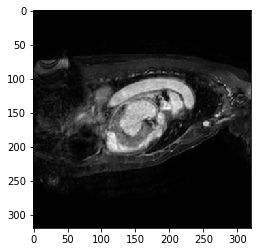

In [4]:
slice_pair = pair.get_pair_slice(40) #take the entire image and label tensor
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]
print("The dimensions of input image is: ", input_slice.shape)

#visualizing the image
img = input_slice
plt.imshow(img,cmap = 'gray')
plt.show()

The dimensions of segmented mask is:  (320, 320)


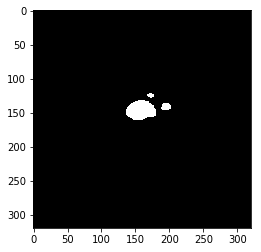

In [5]:
print("The dimensions of segmented mask is: ", gt_slice.shape)

#vizualizing the corresponding mask
img = gt_slice
plt.imshow(img,cmap = 'gray')
plt.show()

get_pair_data- This method is used to fetch the entire image/pixel data and gives us a tuple containing image and mask data

In [6]:
img_data,seg_data = pair.get_pair_data()
print("Shape of image ", img_data.shape)
print("Shape of mask ", seg_data.shape)

Shape of image  (320, 320, 110)
Shape of mask  (320, 320, 110)


# Creating a Dataset for 2D segmentation (slice-wise)

In [7]:
#load inputs ans corresponding segmented areas
img_list = os.listdir(os.path.join(ROOT_DIR,'imagesTr'))
label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))

In [8]:
filename_pairs = [(os.path.join(ROOT_DIR,'imagesTr',x),
                   os.path.join(ROOT_DIR,'labelsTr',y)) for x,y in zip(img_list,label_list)]

In [9]:
print("Number of pairs is: ", len(filename_pairs))
filename_pairs[:2] 

Number of pairs is:  20


[('./Task02_Heart/imagesTr/la_007.nii.gz',
  './Task02_Heart/labelsTr/la_007.nii.gz'),
 ('./Task02_Heart/imagesTr/la_019.nii.gz',
  './Task02_Heart/labelsTr/la_019.nii.gz')]

Apply local distortion and random affine transformation to the train dataset

In [10]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.ElasticTransform(alpha_range=(40.0, 60.0),
                                       sigma_range=(2.5, 4.0),
                                       p=0.3),
        mt_transforms.ToTensor()])

In [11]:
# create a Dataset using the NIFTI images and apply transofmation
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,
                                                     transform=mt_transforms.ToTensor())

In [12]:
print("The size of train dataset is: ", len(train_dataset))

The size of train dataset is:  2271


In [13]:
# an example of particular sample of the training dataset
train_dataset[0]

{'input': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'gt': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetadata at 0x1036fdbe0>,
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0xb21bb2f28>}

# PyTorch Dataloader over Dataset

In [14]:
dataloader = DataLoader(train_dataset, batch_size=2,
                        collate_fn=mt_datasets.mt_collate)

minibatch is basically a dictionary with the relevant image and segment data as well as metadata

In [15]:
batch = next(iter(dataloader))
#particular batch example
batch 

{'input': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'gt': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
  

In [16]:
# check image minibatch size
batch['input'].size()

torch.Size([2, 1, 1600, 1600])

2 - number of batches in one set, 1 - number of color channels, 320 * 320 - pixels of the image (height and weight)

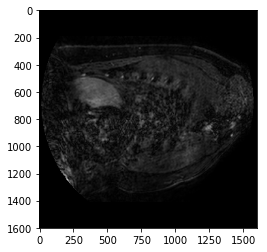

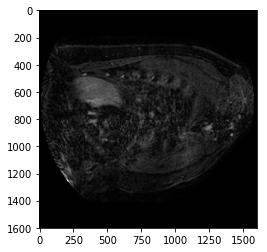

In [17]:
#visualizing the batches in one set
for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

# Constructing The Segmentation Model

In [18]:
#a helper function that helps to decide the final predictions of the model
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

In [19]:
validation_split = 0.8
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, valid_indices = indices[split:], indices[:split]

#samples elements randomly from a given list of indices, without replacement
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(valid_indices)

In [20]:
print("Size of train dataset: ", len(train_dataset))

Size of train dataset:  2271


Define data loaders and split dataset into train and test in proportion 80/20

In [21]:
train_loader = DataLoader(train_dataset, 
                        batch_size=2,
                        collate_fn=mt_datasets.mt_collate,
                        sampler=train_sampler)

val_loader = DataLoader(train_dataset, 
                        batch_size=2,
                        collate_fn=mt_datasets.mt_collate,
                        sampler=val_sampler)

# Model


The model used below refers to the U-net convolutional-based architecture proposed by Ronneberger et al., 2015, which essentially aggregates semantic information to perform the segmentation.

In [22]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
num_epochs = 10 
initial_lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [23]:
#helper functions to produce the desired metrics for the model such as accuracy
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN 
  
def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = np.divide(TP + TN, N)
    return accuracy * 100.0

# Training

We report the training and testing accuracy below and train for 10 epochs

In [ ]:
from tensorboardX import SummaryWriter
import time
torch.cuda.empty_cache() #empty cache of GPU

log_dir = "./Task02_Heart/logs/"
writer = SummaryWriter(logdir=log_dir)

for epoch in tqdm(range(1, num_epochs+1)): #iterate through epochs
    start_time = time.time()

    scheduler.step()

    lr = scheduler.get_lr()[0]
    writer.add_scalar('learning_rate', lr, epoch)
    
    model.train()
    train_loss_total = 0.0
    num_steps = 0
    
    ### Training
    for i, batch in enumerate(train_loader): #iterate through all training examples
        input_samples, gt_samples = batch["input"], batch["gt"]

        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda(non_blocking=True)

        preds = model(var_input) # execute "forward in NN"

        #initialize dice function as loss-function
        loss = mt_losses.dice_loss(preds, var_gt) 
        train_loss_total += loss.item()

        optimizer.zero_grad() #grad=0 and reset
        loss.backward() # back propagation from loss variable
        optimizer.step() # start gradient descend by steps
        num_steps += 1

        if epoch % 5 == 0:
            grid_img = vutils.make_grid(input_samples,
                                        normalize=True,
                                        scale_each=True)
            
            writer.add_image('Input', grid_img, epoch)
            
            grid_img = vutils.make_grid(preds.data.cpu(),
                                        normalize=True,
                                        scale_each=True)
            
            writer.add_image('Predictions', grid_img, epoch)

            grid_img = vutils.make_grid(gt_samples,
                                        normalize=True,
                                        scale_each=True)
            writer.add_image('Ground Truth', grid_img, epoch)
            
    
    train_loss_total_avg = train_loss_total / num_steps
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
    train_acc  = accuracy(preds.cpu().detach().numpy(), 
                          var_gt.cpu().detach().numpy())
    
    metric_fns = [mt_metrics.dice_score,
                  mt_metrics.hausdorff_score,
                  mt_metrics.precision_score,
                  mt_metrics.recall_score,
                  mt_metrics.specificity_score,
                  mt_metrics.intersection_over_union,
                  mt_metrics.accuracy_score]

    metric_mgr = mt_metrics.MetricManager(metric_fns)
    
    ### Validating
    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        with torch.no_grad():
            var_input = input_samples.cuda()
            var_gt = gt_samples.cuda(async=True)

            preds = model(var_input)
            loss = mt_losses.dice_loss(preds, var_gt)
            val_loss_total += loss.item()

        # Metrics computation
        gt_npy = gt_samples.numpy().astype(np.uint8)
        gt_npy = gt_npy.squeeze(axis=1)

        preds = preds.data.cpu().numpy()
        preds = threshold_predictions(preds)
        preds = preds.astype(np.uint8)
        preds = preds.squeeze(axis=1)

        metric_mgr(preds, gt_npy)

        num_steps += 1
        
    metrics_dict = metric_mgr.get_results()
    metric_mgr.reset()
    writer.add_scalars('metrics', metrics_dict, epoch)
    
    val_loss_total_avg = val_loss_total / num_steps
    
    writer.add_scalars('losses', {
                                'val_loss': val_loss_total_avg,
                                'train_loss': train_loss_total_avg
                            }, epoch)
    
    end_time = time.time()
    total_time = end_time - start_time
    
    tqdm.write("Epoch {} took {:.2f} seconds.".format(epoch, total_time))

    writer.add_scalars('losses', {
                                'train_loss': train_loss_total_avg
                            }, epoch)
    
    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, metrics_dict["accuracy_score"]))
 


# Saving the entire model

In [ ]:
torch.cuda.empty_cache()
torch.save(model, os.path.join(ROOT_DIR, 'HeartLeftAtriaSegmentation.pth'))

# Loading the model and making predictions

In [ ]:
model=torch.load('HeartLeftAtriaSegmentation.pth')
model.eval()

In [ ]:
#shows Input image, predicted segmented area by NN and label Segmented Area

for i, batch in enumerate(val_loader): #iterate through all training examples
    input_samples, gt_samples = batch["input"], batch["gt"]
    var_input = input_samples.cuda()
    var_gt = gt_samples.cuda(non_blocking=True)
    preds = model(var_input)

    print(preds.size())
    
    print("Input image")
    item  = batch["input"][0]
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()
    
    print("Predicted Segmented Areas")
    item_predicted = preds[0]
    plt.imshow(item_predicted.cpu().detach().squeeze(0),cmap = 'gray')
    plt.show()

    print("Label Segmented Area")
    item_label = batch["gt"][0]
    plt.imshow(item_label.squeeze(0),cmap = 'gray')
    plt.show()
    
    break